In [1]:
import numpy as np
import random 
from scipy.stats import unitary_group
from scipy.sparse import csr_matrix, kron
import matplotlib.pyplot as plt
from IPython.display import display
from PIL import Image

In [2]:
# defining Pauli matrices & CNOTs
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])

CNOT = [[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]] # control tensor switch
CNOT_12_34 = kron(CNOT, CNOT)

data_13_24 = np.array([1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1])
row_13_24 = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
column_13_24 = np.array([0,1,2,3,5,4,7,6,10,11,8,9,15,14,13,12])
CNOT_13_24 = csr_matrix((data_13_24,(row_13_24,column_13_24)), shape =(16,16))

data_14_23 = np.array([1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1])
row_14_23 = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
column_14_23 = np.array([0,1,2,3,6,7,4,5,9,8,11,10,15,14,13,12])
CNOT_14_23 = csr_matrix((data_14_23,(row_14_23,column_14_23)), shape =(16,16))

CNOTS = [CNOT_12_34,CNOT_13_24,CNOT_14_23]

# defining rotation gates
def Ry(A):
    sn, cs = np.sin(A/2), np.cos(A/2)
    M = np.array([[cs,-sn],[sn, cs]])
    return M
def Rz(A):
    phi = np.exp(-1j*A/2)
    M = np.array([[phi,0],[0,np.conj(phi)]])
    return M
    
#Returns a length-2 array instead of 2x2 matrix. Faster, since it's diagonal. Good for Z rotations!
def Rz2(A):
    phi = np.exp(-1j*A/2)
    return np.array([phi, np.conj(phi)])
    
def Rz2t(A):
    phi = np.exp(-1j*A/2)
    return np.array([[phi], [np.conj(phi)]])

Z2 = np.array([1,-1])
Z2t = np.array([[1],[-1]])
    
# Parameterising the general unitary with rotation gates
def U(A0,A1,A2): # Arguments: Euler Angles
    M = Rz2t(A1) * Ry(A0) * Rz2(A2)
    return M

# derivatives wrt A0,A1,A2
def DA0(A0,A1,A2):
    dA0 = (-1j/2)*(Rz(A1)@Y@Ry(A0)@Rz(A2))
    return dA0
def DA1(A0,A1,A2):
    dA1 = (-1j/2)*(Z@Rz(A1)@Ry(A0)@Rz(A2))
    return dA1
def DA2 (A0,A1,A2):
    dA2 = (-1j/2)*(Rz(A1)@Ry(A0)@Z@Rz(A2))
    return dA2

#Compute U and all three derivatives together, to save computation
def DA_all(A0,A1,A2):
    R1 = Rz2t(A1)
    R0 = Ry(A0)
    R2 = Rz2(A2)
    R02 = R0 * R2
    R102 = R1 * R02
    U = R102
    dA0 = (-0.5j) * R1 * (Y @ R02)
    dA1 = (-0.5j) * Z2t * R102
    dA2 = (-0.5j) * R102 * Z2
    return (U, dA0, dA1, dA2)

# defining inverse
def inverse(M):
    M_inverse = M.transpose().conjugate()
    return M_inverse
    
def parameters(layers): # layers = number of unitary layers, so no-of CNOTs = layers - 1
    A = np.zeros((4*layers,3))
    for i in range(4*layers):
        for j in range(3):
            A[i][j] = random.uniform(0.0, 4*np.pi) 
    return A
    
def Ulist(layers, A):
    U_list=[]
    for i in range(4*layers):
        Ui = U(A[i][0],A[i][1],A[i][2])
        U_list.append(Ui)
    return U_list

#Get the unitary created by these four single-qubit unitaries at layer i.
def U_4squ(A, i):
    U1 = U(A[4*i  ][0],A[4*i  ][1],A[4*i  ][2])
    U2 = U(A[4*i+1][0],A[4*i+1][1],A[4*i+1][2])
    U3 = U(A[4*i+2][0],A[4*i+2][1],A[4*i+2][2])
    U4 = U(A[4*i+3][0],A[4*i+3][1],A[4*i+3][2])
    return np.kron(np.kron(U1, U2), np.kron(U3, U4))

#Like `U_4squ` - But, optionally, skip the single unitary labelled j.
def U_4squ_skip(A, i, j):
    U1 = np.eye(2) if 4*i   == j else U(A[4*i  ][0],A[4*i  ][1],A[4*i  ][2])
    U2 = np.eye(2) if 4*i+1 == j else U(A[4*i+1][0],A[4*i+1][1],A[4*i+1][2])
    U3 = np.eye(2) if 4*i+2 == j else U(A[4*i+2][0],A[4*i+2][1],A[4*i+2][2])
    U4 = np.eye(2) if 4*i+3 == j else U(A[4*i+3][0],A[4*i+3][1],A[4*i+3][2])
    return np.kron(np.kron(U1, U2), np.kron(U3, U4))

#Given a 1-qubit unitary Ui on site s (0-3), expand it to a 4-qubit unitary.
def expand_on_site(Ui, s):
    if s == 0:
        return np.kron(Ui, np.eye(8))
    elif s == 1:
        return np.kron(np.eye(2), np.kron(Ui, np.eye(4)))
    elif s == 2:
        return np.kron(np.eye(4), np.kron(Ui, np.eye(2)))
    elif s == 3:
        return np.kron(np.eye(8), Ui)
    
#Like `U_4squ`, but it's only the unitary at the one site j. That is, it's the single-qubit
#unitary, but expanded to 4-qubits.
def U_4squ_only(A, j):
    # i = j // 4
    # U1 = np.eye(2) if 4*i   != j else U(A[4*i  ][0],A[4*i  ][1],A[4*i  ][2])
    # U2 = np.eye(2) if 4*i+1 != j else U(A[4*i+1][0],A[4*i+1][1],A[4*i+1][2])
    # U3 = np.eye(2) if 4*i+2 != j else U(A[4*i+2][0],A[4*i+2][1],A[4*i+2][2])
    # U4 = np.eye(2) if 4*i+3 != j else U(A[4*i+3][0],A[4*i+3][1],A[4*i+3][2])
    # return np.kron(np.kron(U1, U2), np.kron(U3, U4))
    return expand_on_site(U(A[j][0],A[j][1],A[j][2]), j % 4)
    
#Construct the unitary for the circuit parameterized by "A".
def make_circuit(A, layers):
    U = np.eye(16)
    for i in range(layers-1): #layers-1, because we don't do a CNOT at the end
        U = U @ U_4squ(A, i) @ CNOTS[i%3]
    U = U @ U_4squ(A, layers-1)
    return U

#Measure the error between the circuit parameterized by "A" and U_goal.
def get_error(A, layers, U_goal):
    U = make_circuit(A, layers)
    Tr = np.trace(U @ inverse(U_goal))
    Abs = np.abs(Tr)
    Uerr = 16 - Abs
    return Uerr

def circuit_structure(A, layers, j, U_goal): # qubit number    
    q = (j-1) // 4
    Uf = np.eye(16)
    Ub = np.eye(16)
    for it in range(q):
        Uf = Uf @ U_4squ(A, it) @ CNOTS[it%3]
    Uf = Uf @ U_4squ_skip(A, q, j-1)
    for ib in range(q+1, layers):
        Ub = Ub @ CNOTS[(ib-1)%3] @ U_4squ(A, ib)
    U_tbm = inverse(Uf) @ U_goal @ inverse(Ub) # U_tbm = rhs , U to be made
    return U_tbm

#The trace inner product of two matrices. Equal to np.trace(A @ inverse(B)), but faster
def trace_prod_inv(A, B):
    # return np.trace(A @ inverse(B))
    return np.conj(np.vdot(A, B))

In [3]:
def gradient_descent(layers,U_goal, A, iterations, alpha):
    nsu = 4*layers #(number of single qubit unitaries)
    inner_iterations = int(iterations/10)
    #print(inner_iterations)
    stop_flag=0
    Aopt = np.copy(A) # to separate input and output
    Uerr_array =[]
    for i in range(inner_iterations):
        if i%10==0:
            print("iteration",i)
        if stop_flag ==1:
            print("Truncation")
            break
        for j in range(1, nsu + 1):
            #print("j =",j)
            # rhs of the optimisation
            Ui = circuit_structure(Aopt, layers, j, U_goal)
             # defining LHS
            A0=Aopt[j-1][0]
            A1=Aopt[j-1][1]
            A2=Aopt[j-1][2]
        
            U_initial= U(A0,A1,A2)
            if j%4 == 1:
                U12 = np.kron(U_initial,np.eye(2))
                U34 = np.eye(4)
                Uxyz = np.kron(U12,U34)
            elif j%4 == 2:
                U12 = np.kron(np.eye(2),U_initial)
                U34 = np.eye(4)
                Uxyz = np.kron(U12,U34)
            elif j%4 == 3:
                U12 = np.eye(4)
                U34 =np.kron(U_initial, np.eye(2))
                Uxyz = np.kron(U12,U34)
            elif j%4 == 0 :
                U12 = np.eye(4)
                U34 =np.kron(np.eye(2),U_initial)
                Uxyz = np.kron(U12,U34)
            for k in range(10): # outer iterations
             #defining cost function
                Tr = np.trace(Ui@inverse(Uxyz))
                Abs = np.abs(Tr)
                Uerr = 16 - Abs
                Uerr_array.append(Uerr)
                #print(Uerr)
                if Uerr < 1e-8:
                    stop_flag=1
                    break
                else:
                    #gradient 
                    dA0 = DA0(A0,A1,A2)
                    dA1 = DA1(A0,A1,A2)
                    dA2 = DA2(A0,A1,A2)
                if j%4 == 1:
                    UdA0 = np.kron(np.kron(dA0,np.eye(2)), np.eye(4))
                    UdA1 = np.kron(np.kron(dA1,np.eye(2)), np.eye(4))
                    UdA2 = np.kron(np.kron(dA2,np.eye(2)), np.eye(4))
                elif j%4 == 2:
                    UdA0 = np.kron(np.kron(np.eye(2),dA0), np.eye(4))
                    UdA1 = np.kron(np.kron(np.eye(2),dA1), np.eye(4))
                    UdA2 = np.kron(np.kron(np.eye(2),dA2), np.eye(4))
            
                elif j%4 == 3:
                    UdA0 =np.kron(np.eye(4),np.kron(dA0, np.eye(2)))
                    UdA1 =np.kron(np.eye(4),np.kron(dA1, np.eye(2)))
                    UdA2 =np.kron(np.eye(4),np.kron(dA2, np.eye(2)))
                elif j%4 == 0 :
                    UdA0 =np.kron(np.eye(4),np.kron(np.eye(2),dA0))
                    UdA1 =np.kron(np.eye(4),np.kron(np.eye(2),dA1))
                    UdA2 =np.kron(np.eye(4),np.kron(np.eye(2),dA2))
                Grad_A0 = -np.conj((Tr/Abs))*(np.trace(Ui@inverse(UdA0)))
                Grad_A0R = Grad_A0.real
                Grad_A1 = -np.conj((Tr/Abs))*(np.trace(Ui@inverse(UdA1)))
                Grad_A1R = Grad_A1.real
                Grad_A2 = -np.conj((Tr/Abs))*(np.trace(Ui@inverse(UdA2)))
                Grad_A2R = Grad_A2.real
        
                #updation
                A0 = A0 - alpha*Grad_A0R
                A1 = A1 - alpha*Grad_A1R
                A2 = A2 - alpha*Grad_A2R
                if j%4 == 1:
                    U12 = np.kron(U(A0,A1,A2),np.eye(2))
                    U34 = np.eye(4)
                    Uxyz = np.kron(U12,U34)
                elif j%4 == 2:
                    U12 = np.kron(np.eye(2),U(A0,A1,A2))
                    U34 = np.eye(4)
                    Uxyz = np.kron(U12,U34)
                elif j%4 == 3:
                    U12 = np.eye(4)
                    U34 =np.kron(U(A0,A1,A2), np.eye(2))
                    Uxyz = np.kron(U12,U34)
                elif j%4 == 0 :
                    U12 = np.eye(4)
                    U34 =np.kron(np.eye(2),U(A0,A1,A2))
                    Uxyz = np.kron(U12,U34)
                Aopt[j-1][0]=A0
                Aopt[j-1][1]=A1
                Aopt[j-1][2]=A2
                if stop_flag==1:
                    break
    return Uerr_array
        #return Aopt, stop_flag
                
           
    

In [4]:
#Logically and mathematically equivalent to gradient_descent, but optimized to run faster, mostly by saving products.
def gradient_descent2(layers,U_goal, A, iterations, alpha):
    nsu = 4*layers #(number of single qubit unitaries)
    inner_iterations = int(iterations/10)
    #print(inner_iterations)
    stop_flag=0
    Uerr_array = []

    for i in range(inner_iterations):
        if i%10==0:
            print("iteration",i)
        if stop_flag ==1:
            print("Truncation")
            break

        #Kepp running track of the error: inverse(Uf) * U_goal * inverse(Ub). We'll update this dynamically.
        Ub = U_4squ(A, 0)
        for l in range(1, layers):
            Ub = Ub @ CNOTS[(l-1)%3] @ U_4squ(A, l)
        Ui_err = U_goal @ inverse(Ub)
            
        for l in range(0, layers):            
            for s in [0,1,2,3]:
                        
                j = 4*l+s
                
                # RHS
                Ui_err = Ui_err @ U_4squ_only(A, j)
                
                #Compute the partial trace of Ui, to leave just the `s` qubit part
                if s == 0:
                    Ui2 = np.trace(Ui_err.reshape(2,8, 2,8), axis1=1, axis2=3)
                elif s == 1:
                    Ui2 = Ui_err.reshape(2,2,4, 2,2,4)
                    Ui2 = np.trace(Ui2, axis1=0, axis2=3)
                    Ui2 = np.trace(Ui2, axis1=1, axis2=3)
                elif s == 2:
                    Ui2 = Ui_err.reshape(4,2,2, 4,2,2)
                    Ui2 = np.trace(Ui2, axis1=0, axis2=3)
                    Ui2 = np.trace(Ui2, axis1=1, axis2=3)
                elif s == 3:
                    Ui2 = np.trace(Ui_err.reshape(8,2, 8,2), axis1=0, axis2=2)
                
                # defining LHS
                A0 = A[j][0]
                A1 = A[j][1]
                A2 = A[j][2]
                    
                for k in range(10): # outer iterations
                    #Get new unitary and derivatives
                    Uk, dA0, dA1, dA2 = DA_all(A0,A1,A2)
                    
                    #defining cost function
                    Tr = trace_prod_inv(Ui2, Uk)
                    Abs = np.abs(Tr)
                    Uerr = 16 - Abs
                    Uerr_array.append(Uerr)
                    
                    if Uerr < 1e-8:
                        stop_flag=1
                        break

                    scl = -np.conj(Tr/Abs)
                    Grad_A0R = (scl * trace_prod_inv(Ui2, dA0)).real
                    Grad_A1R = (scl * trace_prod_inv(Ui2, dA1)).real
                    Grad_A2R = (scl * trace_prod_inv(Ui2, dA2)).real
            
                    #update
                    A0 -= alpha*Grad_A0R
                    A1 -= alpha*Grad_A1R
                    A2 -= alpha*Grad_A2R
                    
                A[j][0]=A0
                A[j][1]=A1
                A[j][2]=A2
                
                Ui_err = inverse(U_4squ_only(A, j)) @ Ui_err
                
            Ui_err = CNOTS[l%3] @ Ui_err @ CNOTS[l%3]
            
    return Uerr_array
    #return Aopt, stop_flag

In [5]:
#Replaces computing the gradient + gradual adjustment, with just rounding each goal directly to its nearest unitary
#and using that. Note: no "alpha" for learning rate anymore.
def gradient_descent3(layers,U_goal, A, iterations):
    nsu = 4*layers #(number of single qubit unitaries)
    inner_iterations = int(iterations/10)
    #print(inner_iterations)
    stop_flag=0
    Uerr_array = []

    for i in range(inner_iterations):
        if i%10==0:
            print("iteration",i)
        if stop_flag ==1:
            print("Truncation")
            break

        #Kepp running track of the error: inverse(Uf) * U_goal * inverse(Ub). We'll update this dynamically.
        Ub = U_4squ(A, 0)
        for l in range(1, layers):
            Ub = Ub @ CNOTS[(l-1)%3] @ U_4squ(A, l)
        Ui_err = U_goal @ inverse(Ub)
            
        for l in range(0, layers):            
            for s in [0,1,2,3]:
                j = 4*l+s
                
                # RHS
                Ui_err = Ui_err @ U_4squ_only(A, j)
                
                #Compute the partial trace of Ui, to leave just the `s` qubit part
                if s == 0:
                    Ui2 = np.trace(Ui_err.reshape(2,8, 2,8), axis1=1, axis2=3)
                elif s == 1:
                    Ui2 = Ui_err.reshape(2,2,4, 2,2,4)
                    Ui2 = np.trace(Ui2, axis1=0, axis2=3)
                    Ui2 = np.trace(Ui2, axis1=1, axis2=3)
                elif s == 2:
                    Ui2 = Ui_err.reshape(4,2,2, 4,2,2)
                    Ui2 = np.trace(Ui2, axis1=0, axis2=3)
                    Ui2 = np.trace(Ui2, axis1=1, axis2=3)
                elif s == 3:
                    Ui2 = np.trace(Ui_err.reshape(8,2, 8,2), axis1=0, axis2=2)
                
                #Round goal to nearest unitary
                svd = np.linalg.svd(Ui2)
                unitized = svd[0] @ svd[2]
                unitized /= np.sqrt(np.linalg.det(unitized)) #Convert from U(2) to SU(2)

                # Get Euler angles
                beta = 2 * np.arctan(np.abs(unitized[1][0] / unitized[0][0]))
                phia = np.angle(unitized[0][0])
                phib = np.angle(unitized[1][0])
                a = phib - phia
                c = -(phia + phib)
                
                A[j][0]=beta
                A[j][1]=a
                A[j][2]=c
                
                #computing cost function
                # Uk = U(A0,A1,A2)
                Uk = unitized
                Tr = trace_prod_inv(Ui2, unitized)
                Abs = np.abs(Tr)
                Uerr = 16 - Abs
                Uerr_array.append(Uerr)
                
                Ui_err = inverse(expand_on_site(unitized, s)) @ Ui_err
                
            Ui_err = CNOTS[l%3] @ Ui_err @ CNOTS[l%3]
            
    return Uerr_array
    #return Aopt, stop_flag

In [6]:
import timeit

In [7]:
layers = 35
random.seed(12345)
np.random.seed(12345)
U_goal = (unitary_group.rvs(16))
A = parameters(layers)
#print(np.shape(A))
AOpt =np.copy(A)

Uerr = gradient_descent(layers,U_goal, AOpt, 10, 0.1)
print(Uerr[0], Uerr[1], Uerr[15], Uerr[100], Uerr[-1])

print("Time: ",timeit.Timer(lambda: gradient_descent(layers, U_goal, np.copy(A), 10, 0.1)).timeit(3) / 3)

iteration 0
14.885707880267114 14.771885568705459 14.0620576973663 13.059490400312182 4.91662362077574
iteration 0
iteration 0
iteration 0
Time:  4.843483166666665


In [8]:
layers = 35
random.seed(12345)
np.random.seed(12345)
U_goal = (unitary_group.rvs(16))
#print(U_goal)
A = parameters(layers)
#print(np.shape(A))
AOpt = np.copy(A)

Uerr = gradient_descent2(layers,U_goal, AOpt, 10, 0.1)
print(Uerr[0], Uerr[1], Uerr[15], Uerr[100], Uerr[-1])

print("Time: ",timeit.Timer(lambda: gradient_descent2(layers, U_goal, np.copy(A), 10, 0.1)).timeit(3) / 3)

iteration 0
14.885707880267113 14.771885568705459 14.0620576973663 13.059490400312182 4.916623620775772
iteration 0
iteration 0
iteration 0
Time:  0.2683004000000011


In [10]:
layers = 35
random.seed(12345)
np.random.seed(12345)
U_goal = (unitary_group.rvs(16))
#print(U_goal)
A = parameters(layers)
#print(np.shape(A))
AOpt = np.copy(A)

Uerr = gradient_descent3(layers,U_goal, AOpt, 10000)
print(Uerr[0], Uerr[1], Uerr[2], Uerr[3], Uerr[4], Uerr[-1])

print("Time: ",timeit.Timer(lambda: gradient_descent3(layers, U_goal, np.copy(A), 10)).timeit(3) / 3)

iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 100
iteration 110
iteration 120
iteration 130
iteration 140
iteration 150
iteration 160
iteration 170
iteration 180
iteration 190
iteration 200
iteration 210
iteration 220
iteration 230
iteration 240
iteration 250
iteration 260
iteration 270
iteration 280
iteration 290
iteration 300
iteration 310
iteration 320
iteration 330
iteration 340
iteration 350
iteration 360
iteration 370
iteration 380
iteration 390
iteration 400
iteration 410
iteration 420
iteration 430
iteration 440
iteration 450
iteration 460
iteration 470
iteration 480
iteration 490
iteration 500
iteration 510
iteration 520
iteration 530
iteration 540
iteration 550
iteration 560
iteration 570
iteration 580
iteration 590
iteration 600
iteration 610
iteration 620
iteration 630
iteration 640
iteration 650
iteration 660
iteration 670
iteration 680
iteration 690
iteration 700
iteration 710
ite

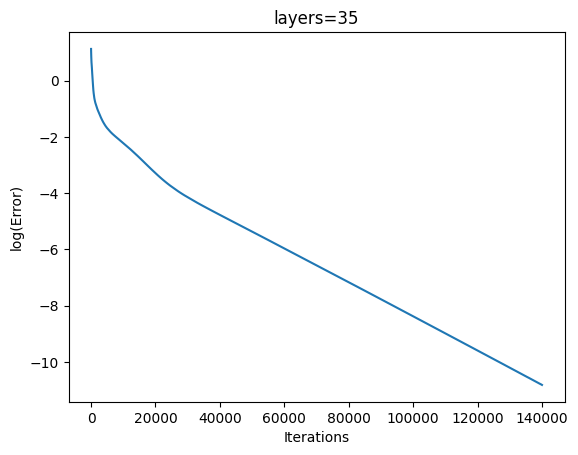

In [11]:
plt.plot(np.log10(Uerr))
plt.title("layers="+str(layers))
plt.xlabel("Iterations")
plt.ylabel("log(Error)")
plt.savefig('4 qubit system layers 35 1.png', bbox_inches='tight')

## Same Unitary- 5 initialisations - 32 layers

In [14]:
layers = 32
U_goal = (unitary_group.rvs(16))
#print(U_goal)
for h in range(5):
    A = parameters(layers)
    #print(np.shape(A))
    AOpt =np.copy(A)
    print("Initialisation:", h+1)
    Uerr = gradient_descent3(layers,U_goal, AOpt, 100000)
    print("\nIterations:",len(Uerr))
    print("Final error:",np.log10(Uerr[-1]))
    plt.plot(np.log10(Uerr))
    plt.title("Initialisation "+str(h+1))
    plt.savefig("Initialisation "+str(h+1))
    plt.close()
    

Initialisation: 1
iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 100
iteration 110
iteration 120
iteration 130
iteration 140
iteration 150
iteration 160
iteration 170
iteration 180
iteration 190
iteration 200
iteration 210
iteration 220
iteration 230
iteration 240
iteration 250
iteration 260
iteration 270
iteration 280
iteration 290
iteration 300
iteration 310
iteration 320
iteration 330
iteration 340
iteration 350
iteration 360
iteration 370
iteration 380
iteration 390
iteration 400
iteration 410
iteration 420
iteration 430
iteration 440
iteration 450
iteration 460
iteration 470
iteration 480
iteration 490
iteration 500
iteration 510
iteration 520
iteration 530
iteration 540
iteration 550
iteration 560
iteration 570
iteration 580
iteration 590
iteration 600
iteration 610
iteration 620
iteration 630
iteration 640
iteration 650
iteration 660
iteration 670
iteration 680
iteration 690
iteration 700

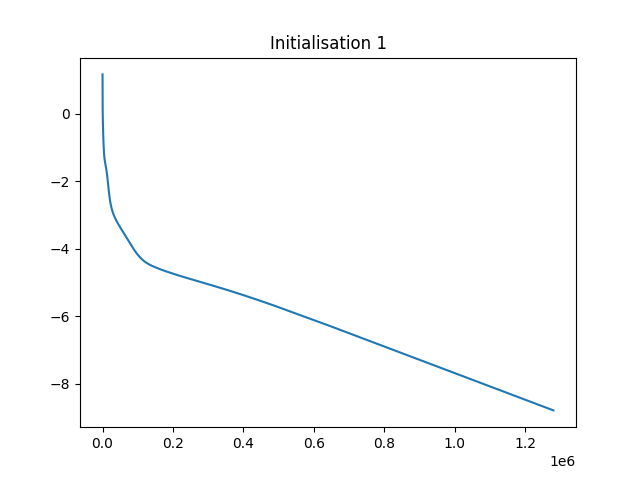

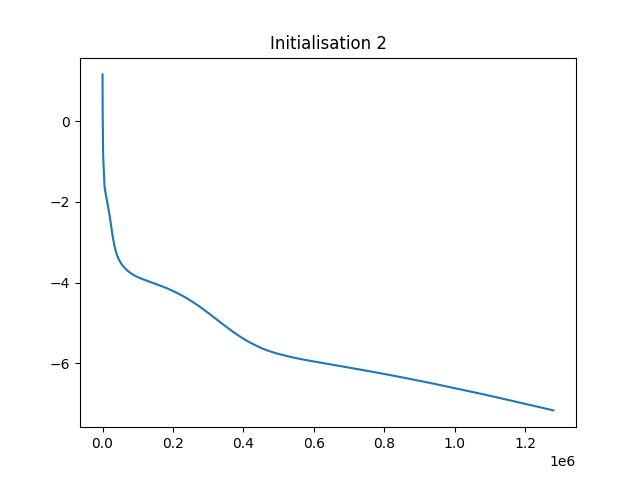

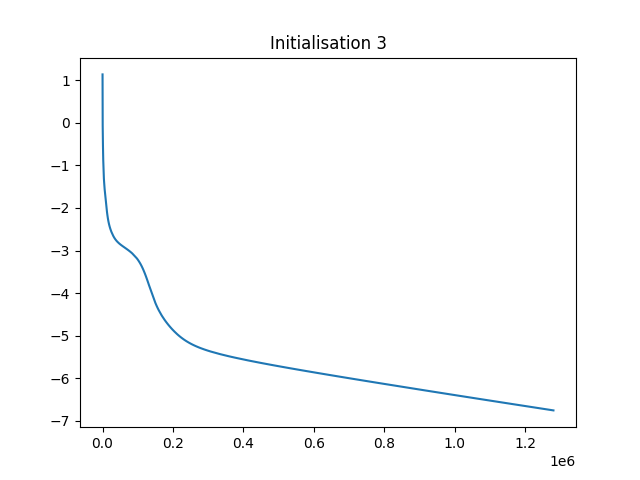

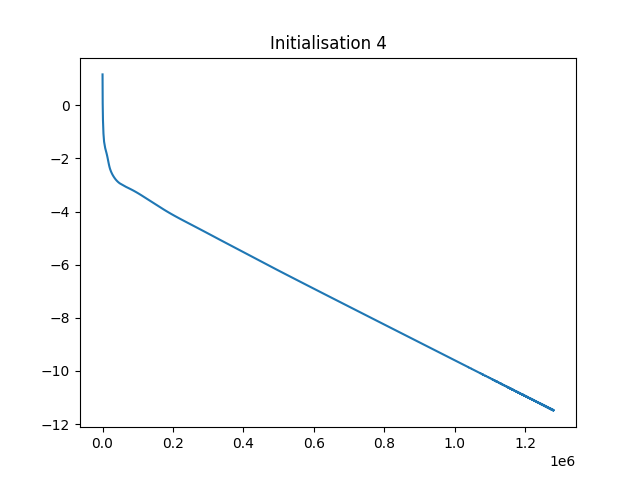

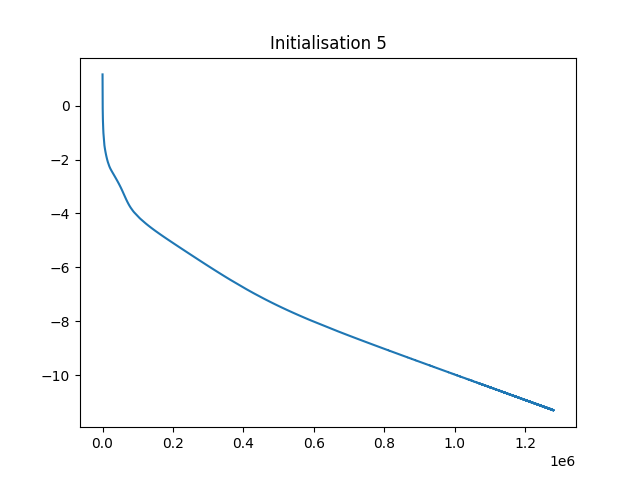

In [16]:
img11 = Image.open("Initialisation 1.png") 
img22 = Image.open("Initialisation 2.png")  
img33 = Image.open("Initialisation 3.png")  
img44 = Image.open("Initialisation 4.png")  
img55 = Image.open("Initialisation 5.png")  # Replace with your filename
display(img11,img22,img33,img44,img55)

## Same Unitary- 5 initialisations - 15 layers

In [29]:
layers = 15
U_goal = (unitary_group.rvs(16))
#print(U_goal)
for h in range(5):
    A = parameters(layers)
    #print(np.shape(A))
    AOpt =np.copy(A)
    print("Initialisation:", h+1)
    Uerr = gradient_descent3(layers,U_goal, AOpt, 10000)
    print("\nIterations:",len(Uerr))
    print("Final error:",np.log10(Uerr[-1]))
    plt.plot(np.log10(Uerr))
    plt.title("Layers=15,Initialisation "+str(h+1))
    plt.text(0.5, 0.95, "Final Error:"+str(np.log10(Uerr[-1])), transform=plt.gca().transAxes,
 fontsize=10, verticalalignment='top')
    plt.savefig("Initialisation "+str(h+1))
    plt.close()
    

Initialisation: 1
iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 100
iteration 110
iteration 120
iteration 130
iteration 140
iteration 150
iteration 160
iteration 170
iteration 180
iteration 190
iteration 200
iteration 210
iteration 220
iteration 230
iteration 240
iteration 250
iteration 260
iteration 270
iteration 280
iteration 290
iteration 300
iteration 310
iteration 320
iteration 330
iteration 340
iteration 350
iteration 360
iteration 370
iteration 380
iteration 390
iteration 400
iteration 410
iteration 420
iteration 430
iteration 440
iteration 450
iteration 460
iteration 470
iteration 480
iteration 490
iteration 500
iteration 510
iteration 520
iteration 530
iteration 540
iteration 550
iteration 560
iteration 570
iteration 580
iteration 590
iteration 600
iteration 610
iteration 620
iteration 630
iteration 640
iteration 650
iteration 660
iteration 670
iteration 680
iteration 690
iteration 700

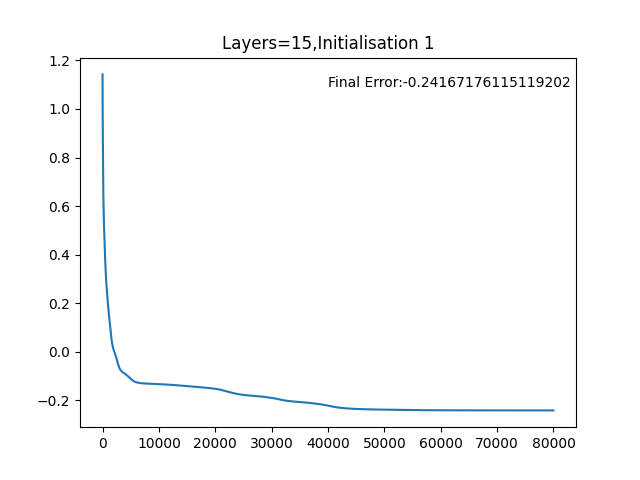

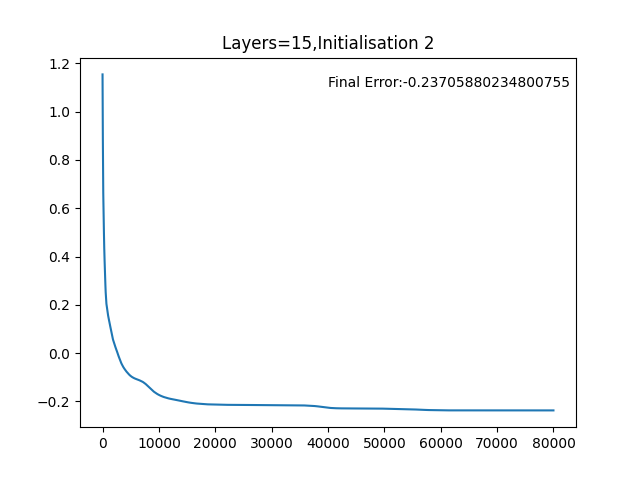

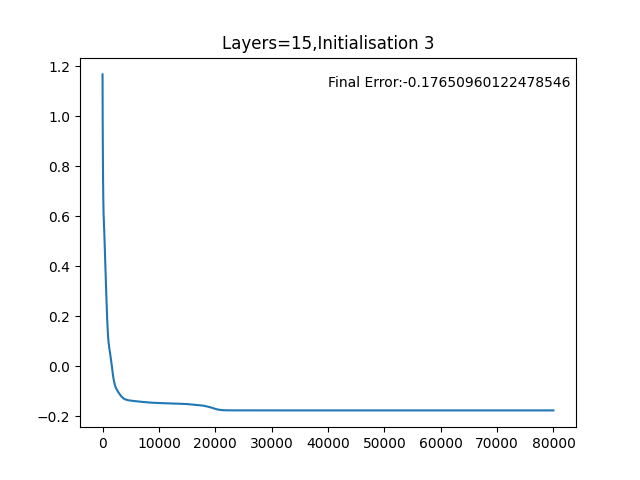

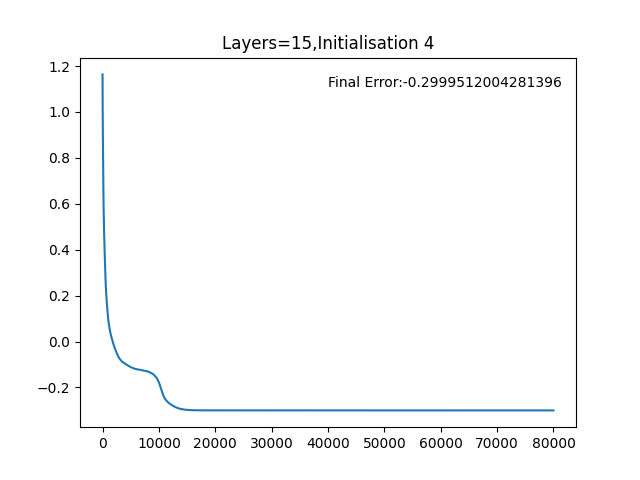

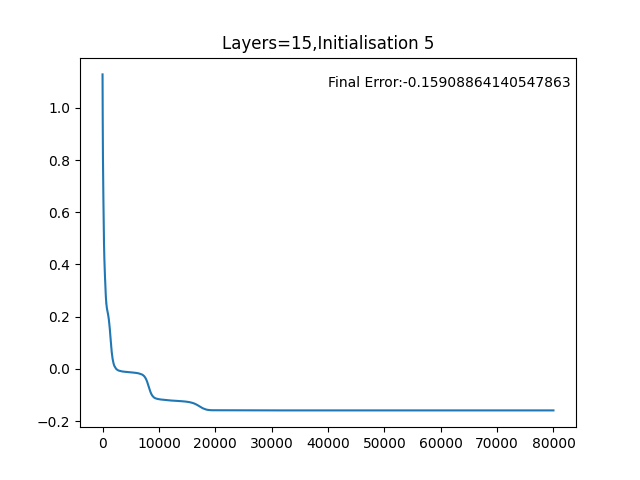

In [38]:
img11 = Image.open("Initialisation 1.png") 
img22 = Image.open("Initialisation 2.png")  
img33 = Image.open("Initialisation 3.png")  
img44 = Image.open("Initialisation 4.png")  
img55 = Image.open("Initialisation 5.png")  # Replace with your filename
display(img11,img22,img33,img44,img55)

## Same Unitary- 5 initialisations - 20 layers

In [40]:
layers = 20
U_goal = (unitary_group.rvs(16))
#print(U_goal)
for h in range(5):
    A = parameters(layers)
    #print(np.shape(A))
    AOpt =np.copy(A)
    print("Initialisation:", h+1)
    Uerr = gradient_descent3(layers,U_goal, AOpt, 10000)
    print("\nIterations:",len(Uerr))
    print("Final error:",np.log10(Uerr[-1]))
    plt.plot(np.log10(Uerr))
    plt.title("Layers=20,Initialisation "+str(h+1))
    plt.text(0.5, 0.95, "Final Error:"+str(np.log10(Uerr[-1])), transform=plt.gca().transAxes,
 fontsize=10, verticalalignment='top')
    plt.savefig("Initialisation "+str(h+1))
    plt.close()

Initialisation: 1
iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 100
iteration 110
iteration 120
iteration 130
iteration 140
iteration 150
iteration 160
iteration 170
iteration 180
iteration 190
iteration 200
iteration 210
iteration 220
iteration 230
iteration 240
iteration 250
iteration 260
iteration 270
iteration 280
iteration 290
iteration 300
iteration 310
iteration 320
iteration 330
iteration 340
iteration 350
iteration 360
iteration 370
iteration 380
iteration 390
iteration 400
iteration 410
iteration 420
iteration 430
iteration 440
iteration 450
iteration 460
iteration 470
iteration 480
iteration 490
iteration 500
iteration 510
iteration 520
iteration 530
iteration 540
iteration 550
iteration 560
iteration 570
iteration 580
iteration 590
iteration 600
iteration 610
iteration 620
iteration 630
iteration 640
iteration 650
iteration 660
iteration 670
iteration 680
iteration 690
iteration 700

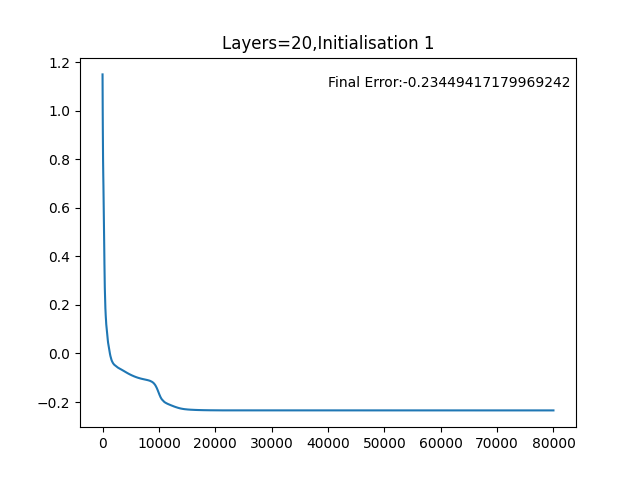

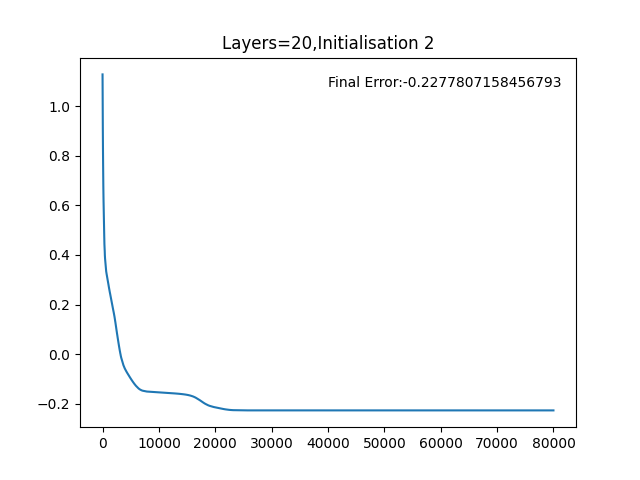

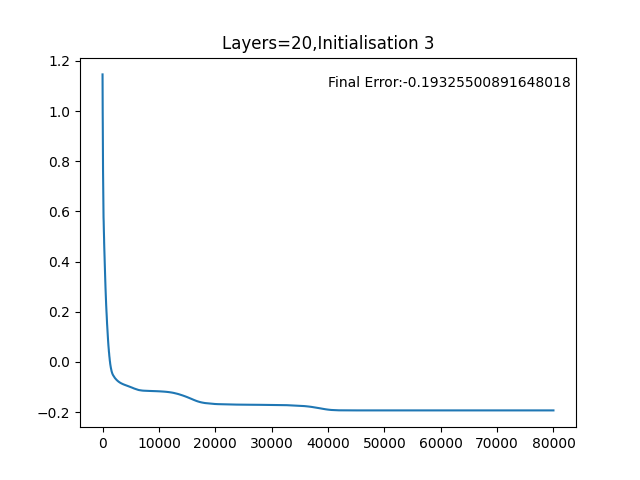

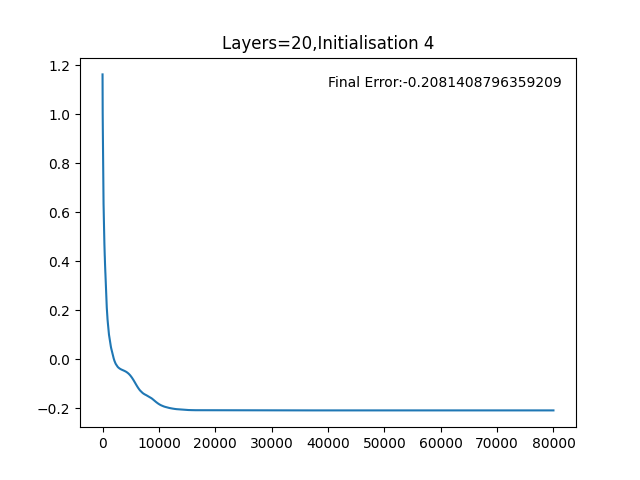

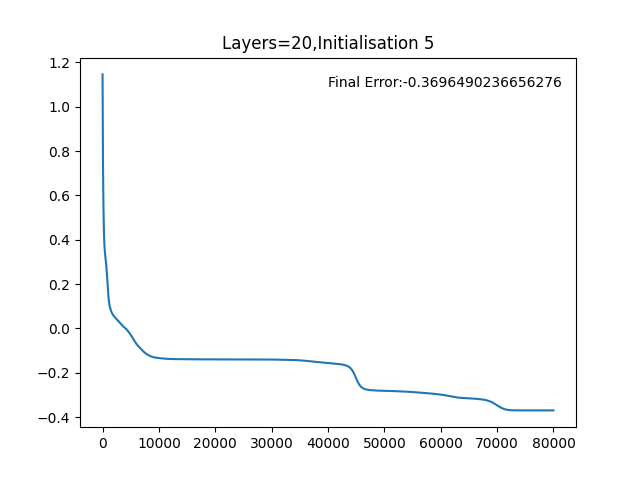

In [41]:
img11 = Image.open("Initialisation 1.png") 
img22 = Image.open("Initialisation 2.png")  
img33 = Image.open("Initialisation 3.png")  
img44 = Image.open("Initialisation 4.png")  
img55 = Image.open("Initialisation 5.png")  # Replace with your filename
display(img11,img22,img33,img44,img55)

## Same Unitary- 5 initialisations - 25 layers

In [51]:
layers = 25
U_goal = (unitary_group.rvs(16))
#print(U_goal)
for h in range(5):
    A = parameters(layers)
    #print(np.shape(A))
    AOpt =np.copy(A)
    print("Initialisation:", h+1)
    Uerr = gradient_descent3(layers,U_goal, AOpt, 50000)
    print("\nIterations:",len(Uerr))
    print("Final error:",np.log10(Uerr[-1]))
    plt.plot(np.log10(Uerr))
    plt.title("Layers=25,Initialisation "+str(h+1))
    plt.text(0.5, 0.95, "Final Error:"+str(np.log10(Uerr[-1])), transform=plt.gca().transAxes,
 fontsize=10, verticalalignment='top')
    plt.savefig("Initialisation "+str(h+1))
    plt.close()

Initialisation: 1
iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 100
iteration 110
iteration 120
iteration 130
iteration 140
iteration 150
iteration 160
iteration 170
iteration 180
iteration 190
iteration 200
iteration 210
iteration 220
iteration 230
iteration 240
iteration 250
iteration 260
iteration 270
iteration 280
iteration 290
iteration 300
iteration 310
iteration 320
iteration 330
iteration 340
iteration 350
iteration 360
iteration 370
iteration 380
iteration 390
iteration 400
iteration 410
iteration 420
iteration 430
iteration 440
iteration 450
iteration 460
iteration 470
iteration 480
iteration 490
iteration 500
iteration 510
iteration 520
iteration 530
iteration 540
iteration 550
iteration 560
iteration 570
iteration 580
iteration 590
iteration 600
iteration 610
iteration 620
iteration 630
iteration 640
iteration 650
iteration 660
iteration 670
iteration 680
iteration 690
iteration 700

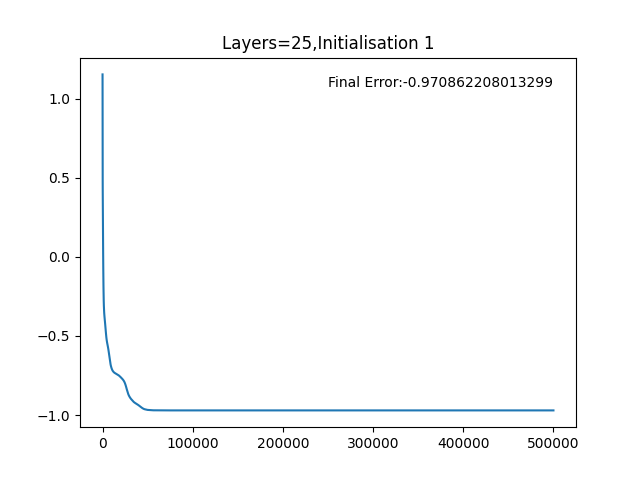

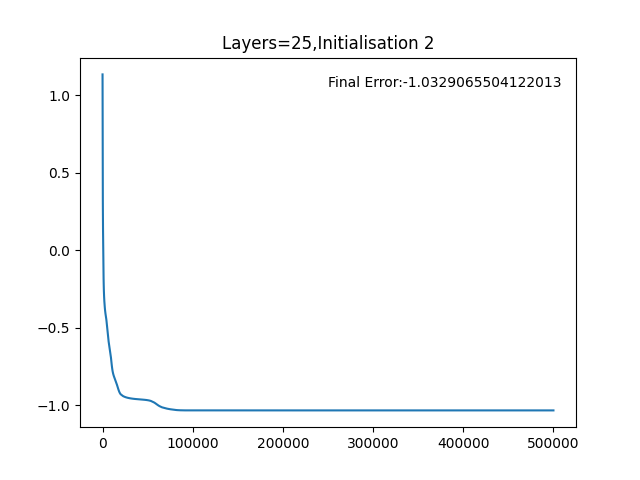

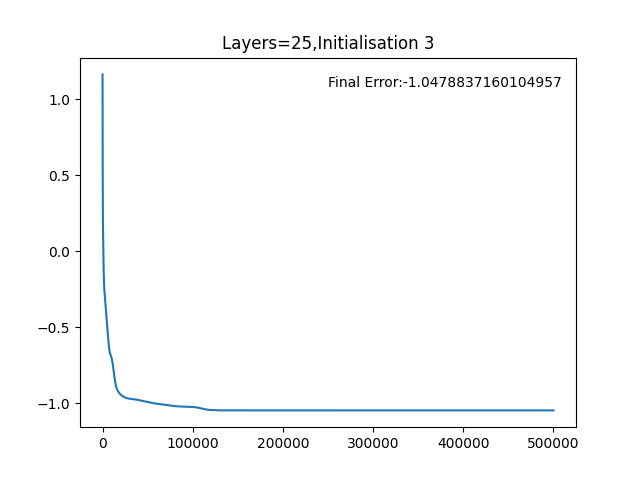

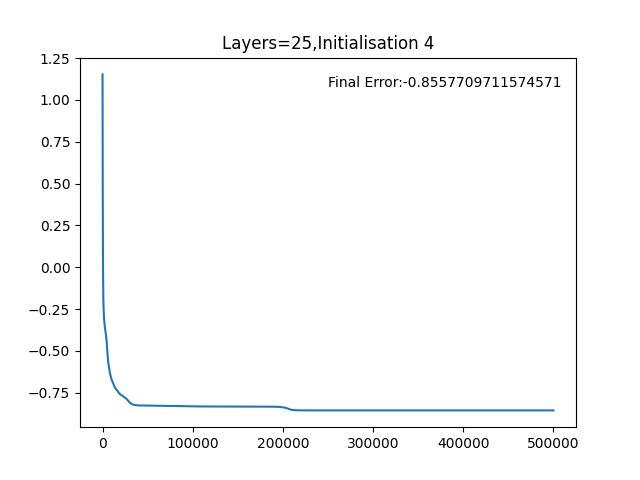

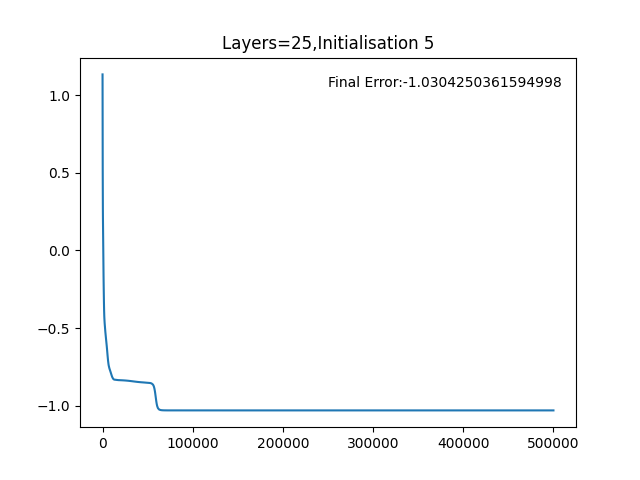

In [52]:
img11 = Image.open("Initialisation 1.png") 
img22 = Image.open("Initialisation 2.png")  
img33 = Image.open("Initialisation 3.png")  
img44 = Image.open("Initialisation 4.png")  
img55 = Image.open("Initialisation 5.png")  # Replace with your filename
display(img11,img22,img33,img44,img55)

## Same Unitary- 5 initialisations - 30 layers

In [57]:
layers = 30
U_goal = (unitary_group.rvs(16))
#print(U_goal)
for h in range(5):
    A = parameters(layers)
    #print(np.shape(A))
    AOpt =np.copy(A)
    print("Initialisation:", h+1)
    Uerr = gradient_descent3(layers,U_goal, AOpt, 100000)
    print("\nIterations:",len(Uerr))
    print("Final error:",np.log10(Uerr[-1]))
    plt.plot(np.log10(Uerr))
    plt.title("Layers=30,Initialisation "+str(h+1))
    plt.text(0.5, 0.95, "Final Error:"+str(np.log10(Uerr[-1])), transform=plt.gca().transAxes,
 fontsize=10, verticalalignment='top')
    plt.savefig("Initialisation "+str(h+1))
    plt.close()

Initialisation: 1
iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 100
iteration 110
iteration 120
iteration 130
iteration 140
iteration 150
iteration 160
iteration 170
iteration 180
iteration 190
iteration 200
iteration 210
iteration 220
iteration 230
iteration 240
iteration 250
iteration 260
iteration 270
iteration 280
iteration 290
iteration 300
iteration 310
iteration 320
iteration 330
iteration 340
iteration 350
iteration 360
iteration 370
iteration 380
iteration 390
iteration 400
iteration 410
iteration 420
iteration 430
iteration 440
iteration 450
iteration 460
iteration 470
iteration 480
iteration 490
iteration 500
iteration 510
iteration 520
iteration 530
iteration 540
iteration 550
iteration 560
iteration 570
iteration 580
iteration 590
iteration 600
iteration 610
iteration 620
iteration 630
iteration 640
iteration 650
iteration 660
iteration 670
iteration 680
iteration 690
iteration 700

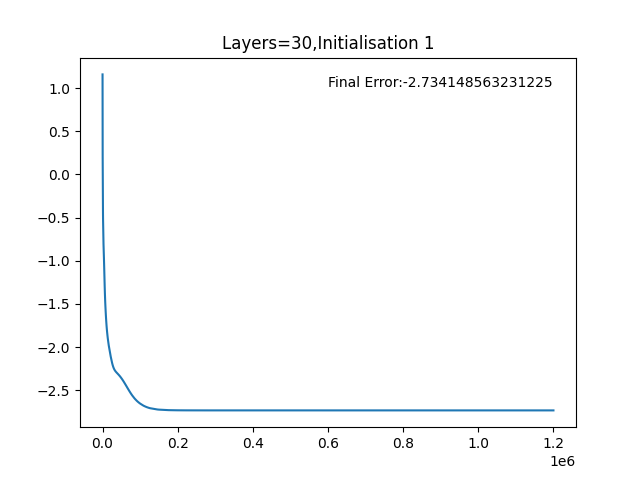

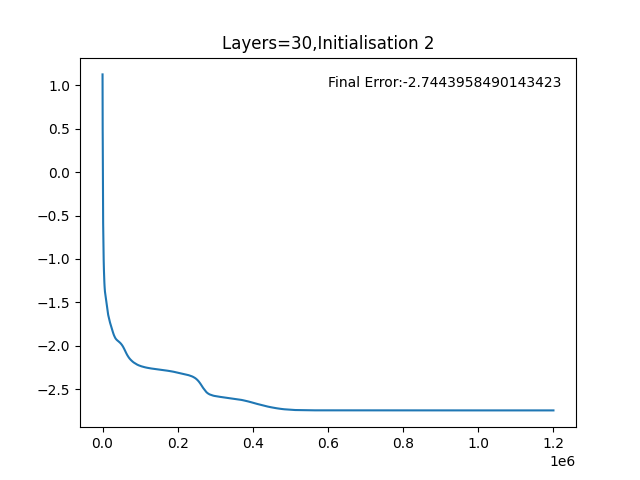

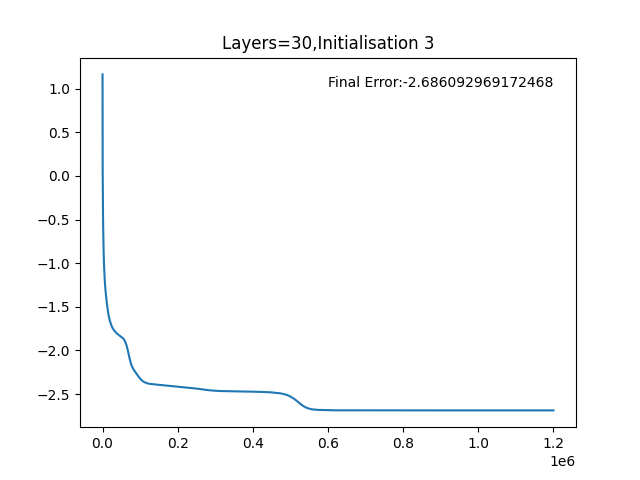

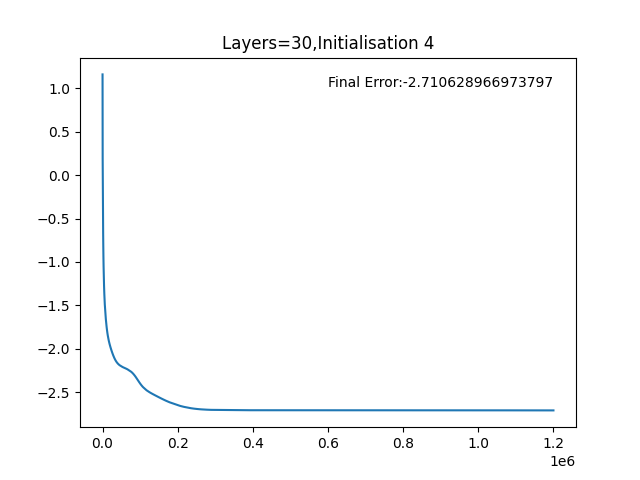

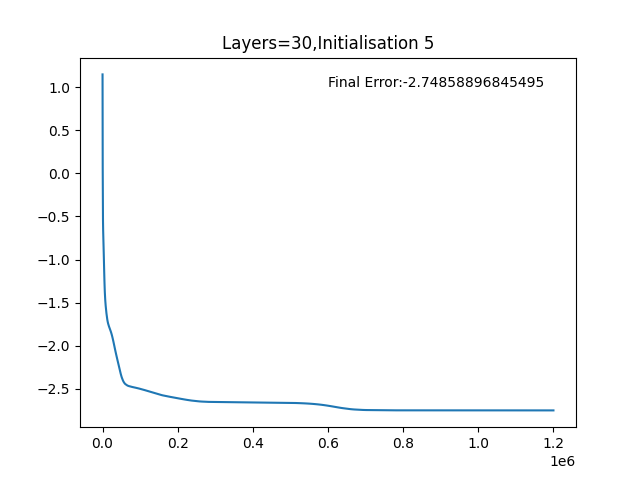

In [59]:
img11 = Image.open("Initialisation 1.png") 
img22 = Image.open("Initialisation 2.png")  
img33 = Image.open("Initialisation 3.png")  
img44 = Image.open("Initialisation 4.png")  
img55 = Image.open("Initialisation 5.png")  # Replace with your filename
display(img11,img22,img33,img44,img55)

## Same Unitary for Layers 15,20,25,32

In [76]:
layers_list = [32,20,25,30,15]
U_goal = (unitary_group.rvs(16))
#print(U_goal)
A = parameters(layers)
#print(np.shape(A))
AOpt =np.copy(A)
for h in range(5):
    print("Layers:", layers_list[h])
    if layers_list[h]==15 or layers_list[h]==20:
        Uerr = gradient_descent3(layers_list[h],U_goal, AOpt, 10000)
    elif layers_list[h]==25:
        Uerr = gradient_descent3(layers_list[h],U_goal, AOpt, 50000)
    else:
        Uerr = gradient_descent3(layers_list[h],U_goal, AOpt, 100000)
    print("\nIterations:",len(Uerr))
    print("Final error:",np.log10(Uerr[-1]))
    plt.plot(np.log10(Uerr))
    plt.title("Layers:"+str(layers_list[h]))
    plt.text(0.05, 0.95, "Final Error:"+str(np.log10(Uerr[-1])), transform=plt.gca().transAxes,
     fontsize=12, verticalalignment='top')
    plt.savefig("Layers "+str(layers_list[h]))
    plt.close()

Layers: 32
iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 100
iteration 110
iteration 120
iteration 130
iteration 140
iteration 150
iteration 160
iteration 170
iteration 180
iteration 190
iteration 200
iteration 210
iteration 220
iteration 230
iteration 240
iteration 250
iteration 260
iteration 270
iteration 280
iteration 290
iteration 300
iteration 310
iteration 320
iteration 330
iteration 340
iteration 350
iteration 360
iteration 370
iteration 380
iteration 390
iteration 400
iteration 410
iteration 420
iteration 430
iteration 440
iteration 450
iteration 460
iteration 470
iteration 480
iteration 490
iteration 500
iteration 510
iteration 520
iteration 530
iteration 540
iteration 550
iteration 560
iteration 570
iteration 580
iteration 590
iteration 600
iteration 610
iteration 620
iteration 630
iteration 640
iteration 650
iteration 660
iteration 670
iteration 680
iteration 690
iteration 700
iterat

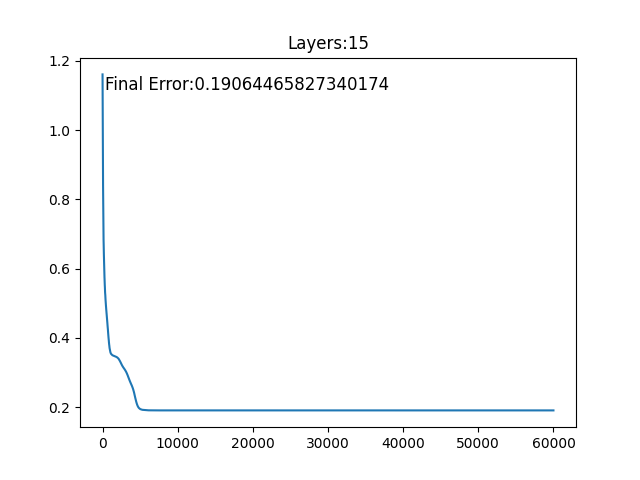

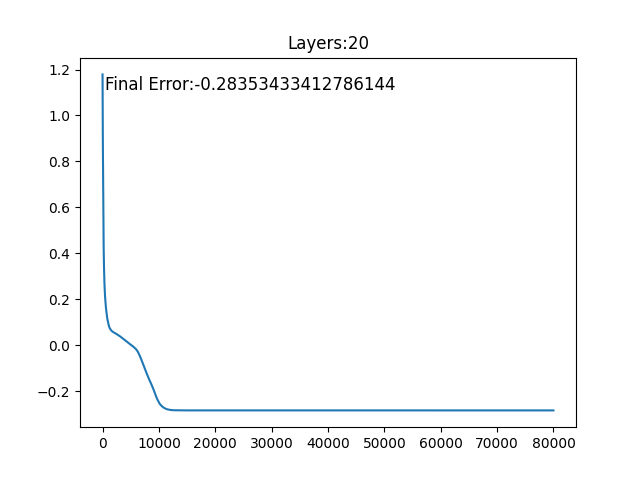

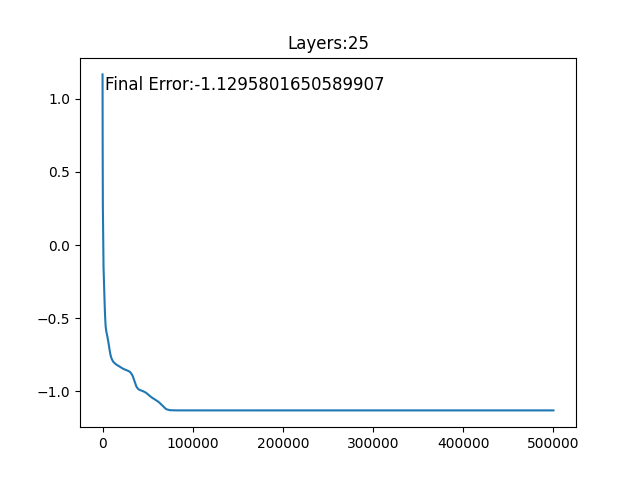

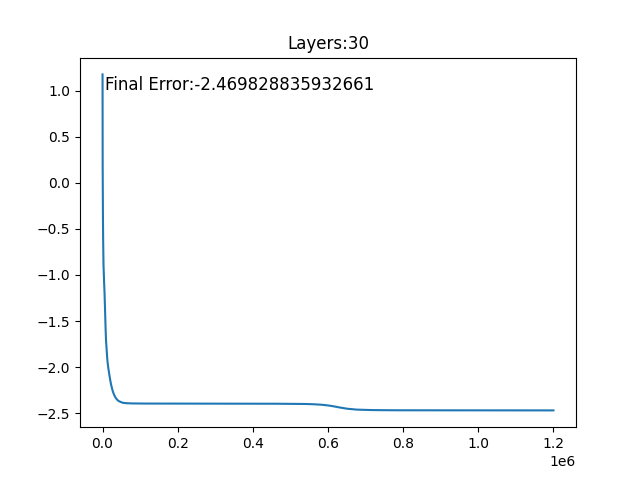

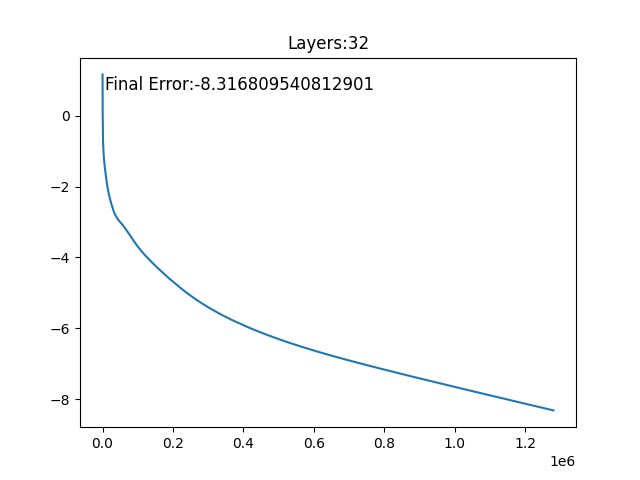

In [77]:
img11 = Image.open("Layers 15.png") 
img22 = Image.open("Layers 20.png")  
img33 = Image.open("Layers 25.png")  
img44 = Image.open("Layers 30.png")  
img55 = Image.open("Layers 32.png") 
display(img11,img22,img33,img44,img55)